In [28]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [29]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

D:\Anoconda3\envs\tf\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [30]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\原数据\K_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:4]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        layers.Dropout(0.5),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.001
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [31]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [32]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [33]:
batch_size=256

In [34]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\不自然数据\1正2345负')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [35]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [36]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [37]:
prediction_result_cv = []
prediction_result_ind = []

In [38]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1')

In [39]:
out = os.getcwd() + '\\'

In [40]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0  

8/8 - 0s - loss: 0.5934 - accuracy: 0.6836 - val_loss: 0.6355 - val_accuracy: 0.6489

Epoch 00027: val_loss did not improve from 0.63243
Epoch 28/300
8/8 - 0s - loss: 0.5870 - accuracy: 0.6940 - val_loss: 0.6408 - val_accuracy: 0.6533

Epoch 00028: val_loss did not improve from 0.63243
Epoch 29/300
8/8 - 0s - loss: 0.5881 - accuracy: 0.6925 - val_loss: 0.6380 - val_accuracy: 0.6356

Epoch 00029: val_loss did not improve from 0.63243
Epoch 30/300
8/8 - 0s - loss: 0.5652 - accuracy: 0.7098 - val_loss: 0.6397 - val_accuracy: 0.6089

Epoch 00030: val_loss did not improve from 0.63243
Epoch 31/300
8/8 - 0s - loss: 0.5697 - accuracy: 0.7059 - val_loss: 0.6313 - val_accuracy: 0.6311

Epoch 00031: val_loss improved from 0.63243 to 0.63127, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_0.h5
Epoch 32/300
8/8 - 0s - loss: 0.5784 - accuracy: 0.7029 - val_loss: 0.6336 - val_accuracy: 0.6311

Epoch 00032: val_loss did 

8/8 - 0s - loss: 0.4380 - accuracy: 0.7919 - val_loss: 0.6642 - val_accuracy: 0.6000

Epoch 00080: val_loss did not improve from 0.62932
Epoch 81/300
8/8 - 0s - loss: 0.4219 - accuracy: 0.7988 - val_loss: 0.7139 - val_accuracy: 0.5733

Epoch 00081: val_loss did not improve from 0.62932
Epoch 82/300
8/8 - 0s - loss: 0.4168 - accuracy: 0.8107 - val_loss: 0.6742 - val_accuracy: 0.6222

Epoch 00082: val_loss did not improve from 0.62932
Epoch 83/300
8/8 - 0s - loss: 0.4295 - accuracy: 0.7983 - val_loss: 0.6598 - val_accuracy: 0.6089

Epoch 00083: val_loss did not improve from 0.62932
Epoch 84/300
8/8 - 0s - loss: 0.4184 - accuracy: 0.8072 - val_loss: 0.6655 - val_accuracy: 0.6178

Epoch 00084: val_loss did not improve from 0.62932
Epoch 85/300
8/8 - 0s - loss: 0.4085 - accuracy: 0.8112 - val_loss: 0.6759 - val_accuracy: 0.6133

Epoch 00085: val_loss did not improve from 0.62932
1
Model: "model_11"
_________________________________________________________________
Layer (type)               

8/8 - 0s - loss: 0.6156 - accuracy: 0.6644 - val_loss: 0.6395 - val_accuracy: 0.6489

Epoch 00018: val_loss improved from 0.64387 to 0.63951, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_1.h5
Epoch 19/300
8/8 - 0s - loss: 0.6191 - accuracy: 0.6663 - val_loss: 0.6417 - val_accuracy: 0.6356

Epoch 00019: val_loss did not improve from 0.63951
Epoch 20/300
8/8 - 0s - loss: 0.6027 - accuracy: 0.6817 - val_loss: 0.6454 - val_accuracy: 0.6267

Epoch 00020: val_loss did not improve from 0.63951
Epoch 21/300
8/8 - 0s - loss: 0.6131 - accuracy: 0.6693 - val_loss: 0.6419 - val_accuracy: 0.6400

Epoch 00021: val_loss did not improve from 0.63951
Epoch 22/300
8/8 - 0s - loss: 0.6030 - accuracy: 0.6723 - val_loss: 0.6413 - val_accuracy: 0.6356

Epoch 00022: val_loss did not improve from 0.63951
Epoch 23/300
8/8 - 0s - loss: 0.6132 - accuracy: 0.6733 - val_loss: 0.6571 - val_accuracy: 0.5733

Epoch 00023: val_loss did 


Epoch 00066: val_loss did not improve from 0.62149
Epoch 67/300
8/8 - 0s - loss: 0.4969 - accuracy: 0.7701 - val_loss: 0.6398 - val_accuracy: 0.6400

Epoch 00067: val_loss did not improve from 0.62149
Epoch 68/300
8/8 - 0s - loss: 0.4902 - accuracy: 0.7583 - val_loss: 0.6409 - val_accuracy: 0.6267

Epoch 00068: val_loss did not improve from 0.62149
Epoch 69/300
8/8 - 0s - loss: 0.4618 - accuracy: 0.7889 - val_loss: 0.6441 - val_accuracy: 0.6400

Epoch 00069: val_loss did not improve from 0.62149
Epoch 70/300
8/8 - 0s - loss: 0.4674 - accuracy: 0.7785 - val_loss: 0.6521 - val_accuracy: 0.6178

Epoch 00070: val_loss did not improve from 0.62149
Epoch 71/300
8/8 - 0s - loss: 0.4778 - accuracy: 0.7662 - val_loss: 0.6411 - val_accuracy: 0.6178

Epoch 00071: val_loss did not improve from 0.62149
Epoch 72/300
8/8 - 0s - loss: 0.4373 - accuracy: 0.8087 - val_loss: 0.6466 - val_accuracy: 0.6267

Epoch 00072: val_loss did not improve from 0.62149
Epoch 73/300
8/8 - 0s - loss: 0.4481 - accuracy:

8/8 - 1s - loss: 0.6893 - accuracy: 0.5314 - val_loss: 0.6900 - val_accuracy: 0.5333

Epoch 00001: val_loss improved from inf to 0.68999, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_2.h5
Epoch 2/300
8/8 - 0s - loss: 0.6679 - accuracy: 0.5833 - val_loss: 0.6780 - val_accuracy: 0.5956

Epoch 00002: val_loss improved from 0.68999 to 0.67805, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_2.h5
Epoch 3/300
8/8 - 0s - loss: 0.6613 - accuracy: 0.5981 - val_loss: 0.6754 - val_accuracy: 0.6133

Epoch 00003: val_loss improved from 0.67805 to 0.67539, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_2.h5
Epoch 4/300
8/8 - 0s - loss: 0.6551 - accuracy: 0.6243 - val_loss: 0.6801 - val_accuracy: 0.5911

Epoch 00004: val_loss did not improve from 0.67539
Epoch 

8/8 - 0s - loss: 0.5329 - accuracy: 0.7311 - val_loss: 0.7008 - val_accuracy: 0.5867

Epoch 00043: val_loss did not improve from 0.65824
Epoch 44/300
8/8 - 0s - loss: 0.5469 - accuracy: 0.7247 - val_loss: 0.6819 - val_accuracy: 0.5778

Epoch 00044: val_loss did not improve from 0.65824
Epoch 45/300
8/8 - 0s - loss: 0.5415 - accuracy: 0.7217 - val_loss: 0.6687 - val_accuracy: 0.5911

Epoch 00045: val_loss did not improve from 0.65824
Epoch 46/300
8/8 - 0s - loss: 0.5216 - accuracy: 0.7439 - val_loss: 0.6665 - val_accuracy: 0.5956

Epoch 00046: val_loss did not improve from 0.65824
Epoch 47/300
8/8 - 0s - loss: 0.5249 - accuracy: 0.7385 - val_loss: 0.6613 - val_accuracy: 0.6311

Epoch 00047: val_loss did not improve from 0.65824
Epoch 48/300
8/8 - 0s - loss: 0.5131 - accuracy: 0.7484 - val_loss: 0.7860 - val_accuracy: 0.5689

Epoch 00048: val_loss did not improve from 0.65824
Epoch 49/300
8/8 - 0s - loss: 0.5350 - accuracy: 0.7420 - val_loss: 0.6625 - val_accuracy: 0.5778

Epoch 00049: v

8/8 - 1s - loss: 0.6878 - accuracy: 0.5309 - val_loss: 0.6752 - val_accuracy: 0.6356

Epoch 00001: val_loss improved from inf to 0.67522, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_3.h5
Epoch 2/300
8/8 - 0s - loss: 0.6797 - accuracy: 0.5561 - val_loss: 0.6663 - val_accuracy: 0.6400

Epoch 00002: val_loss improved from 0.67522 to 0.66634, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_3.h5
Epoch 3/300
8/8 - 0s - loss: 0.6682 - accuracy: 0.5803 - val_loss: 0.6609 - val_accuracy: 0.6311

Epoch 00003: val_loss improved from 0.66634 to 0.66094, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_3.h5
Epoch 4/300
8/8 - 0s - loss: 0.6602 - accuracy: 0.6060 - val_loss: 0.6600 - val_accuracy: 0.6533

Epoch 00004: val_loss improved from 0.66094 to 0.65999, s

8/8 - 0s - loss: 0.5249 - accuracy: 0.7355 - val_loss: 0.6504 - val_accuracy: 0.6578

Epoch 00043: val_loss did not improve from 0.63515
Epoch 44/300
8/8 - 0s - loss: 0.5410 - accuracy: 0.7291 - val_loss: 0.6873 - val_accuracy: 0.5956

Epoch 00044: val_loss did not improve from 0.63515
Epoch 45/300
8/8 - 0s - loss: 0.5241 - accuracy: 0.7410 - val_loss: 0.6397 - val_accuracy: 0.6756

Epoch 00045: val_loss did not improve from 0.63515
Epoch 46/300
8/8 - 0s - loss: 0.5548 - accuracy: 0.7084 - val_loss: 0.6387 - val_accuracy: 0.6489

Epoch 00046: val_loss did not improve from 0.63515
Epoch 47/300
8/8 - 0s - loss: 0.5175 - accuracy: 0.7563 - val_loss: 0.6490 - val_accuracy: 0.6578

Epoch 00047: val_loss did not improve from 0.63515
Epoch 48/300
8/8 - 0s - loss: 0.5241 - accuracy: 0.7435 - val_loss: 0.6437 - val_accuracy: 0.6578

Epoch 00048: val_loss did not improve from 0.63515
Epoch 49/300
8/8 - 0s - loss: 0.5268 - accuracy: 0.7336 - val_loss: 0.6456 - val_accuracy: 0.6533

Epoch 00049: v

8/8 - 0s - loss: 0.3776 - accuracy: 0.8314 - val_loss: 0.7122 - val_accuracy: 0.6000

Epoch 00097: val_loss did not improve from 0.63324
Epoch 98/300
8/8 - 0s - loss: 0.3724 - accuracy: 0.8334 - val_loss: 0.6446 - val_accuracy: 0.6711

Epoch 00098: val_loss did not improve from 0.63324
Epoch 99/300
8/8 - 0s - loss: 0.3991 - accuracy: 0.8220 - val_loss: 0.6411 - val_accuracy: 0.6622

Epoch 00099: val_loss did not improve from 0.63324
Epoch 100/300
8/8 - 0s - loss: 0.3622 - accuracy: 0.8453 - val_loss: 0.6472 - val_accuracy: 0.6667

Epoch 00100: val_loss did not improve from 0.63324
Epoch 101/300
8/8 - 0s - loss: 0.3520 - accuracy: 0.8547 - val_loss: 0.6798 - val_accuracy: 0.6489

Epoch 00101: val_loss did not improve from 0.63324
Epoch 102/300
8/8 - 0s - loss: 0.3467 - accuracy: 0.8389 - val_loss: 0.6570 - val_accuracy: 0.6844

Epoch 00102: val_loss did not improve from 0.63324
Epoch 103/300
8/8 - 0s - loss: 0.4050 - accuracy: 0.8092 - val_loss: 0.6409 - val_accuracy: 0.6711

Epoch 0010


Epoch 00005: val_loss improved from 0.66404 to 0.66194, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_4.h5
Epoch 6/300
8/8 - 0s - loss: 0.6477 - accuracy: 0.6204 - val_loss: 0.6567 - val_accuracy: 0.6089

Epoch 00006: val_loss improved from 0.66194 to 0.65671, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_4.h5
Epoch 7/300
8/8 - 0s - loss: 0.6475 - accuracy: 0.6317 - val_loss: 0.6589 - val_accuracy: 0.5911

Epoch 00007: val_loss did not improve from 0.65671
Epoch 8/300
8/8 - 0s - loss: 0.6481 - accuracy: 0.6159 - val_loss: 0.6550 - val_accuracy: 0.5911

Epoch 00008: val_loss improved from 0.65671 to 0.65495, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_4.h5
Epoch 9/300
8/8 - 0s - loss: 0.6447 - accuracy: 0.6416 - val_loss: 0.6674 - val_accurac


Epoch 00045: val_loss did not improve from 0.61432
Epoch 46/300
8/8 - 0s - loss: 0.5182 - accuracy: 0.7504 - val_loss: 0.6163 - val_accuracy: 0.6489

Epoch 00046: val_loss did not improve from 0.61432
Epoch 47/300
8/8 - 0s - loss: 0.5297 - accuracy: 0.7385 - val_loss: 0.6221 - val_accuracy: 0.6578

Epoch 00047: val_loss did not improve from 0.61432
Epoch 48/300
8/8 - 0s - loss: 0.5191 - accuracy: 0.7474 - val_loss: 0.6159 - val_accuracy: 0.6400

Epoch 00048: val_loss did not improve from 0.61432
Epoch 49/300
8/8 - 0s - loss: 0.5426 - accuracy: 0.7385 - val_loss: 0.6170 - val_accuracy: 0.6622

Epoch 00049: val_loss did not improve from 0.61432
Epoch 50/300
8/8 - 0s - loss: 0.5252 - accuracy: 0.7281 - val_loss: 0.6119 - val_accuracy: 0.6533

Epoch 00050: val_loss improved from 0.61432 to 0.61192, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_4.h5
Epoch 51/300
8/8 - 0s - loss: 0.5309 - accuracy: 0.7380 - va


Epoch 00096: val_loss did not improve from 0.60243
Epoch 97/300
8/8 - 0s - loss: 0.3725 - accuracy: 0.8393 - val_loss: 0.6235 - val_accuracy: 0.6356

Epoch 00097: val_loss did not improve from 0.60243
Epoch 98/300
8/8 - 0s - loss: 0.3868 - accuracy: 0.8230 - val_loss: 0.6297 - val_accuracy: 0.6400

Epoch 00098: val_loss did not improve from 0.60243
Epoch 99/300
8/8 - 0s - loss: 0.4031 - accuracy: 0.8166 - val_loss: 0.6161 - val_accuracy: 0.6400

Epoch 00099: val_loss did not improve from 0.60243
Epoch 100/300
8/8 - 0s - loss: 0.3851 - accuracy: 0.8245 - val_loss: 0.6240 - val_accuracy: 0.6400

Epoch 00100: val_loss did not improve from 0.60243
Epoch 101/300
8/8 - 0s - loss: 0.3619 - accuracy: 0.8438 - val_loss: 0.6075 - val_accuracy: 0.6844

Epoch 00101: val_loss did not improve from 0.60243
Epoch 102/300
8/8 - 0s - loss: 0.3623 - accuracy: 0.8374 - val_loss: 0.6266 - val_accuracy: 0.6311

Epoch 00102: val_loss did not improve from 0.60243
Epoch 103/300
8/8 - 0s - loss: 0.3827 - accur

8/8 - 0s - loss: 0.6264 - accuracy: 0.6555 - val_loss: 0.6534 - val_accuracy: 0.5733

Epoch 00011: val_loss did not improve from 0.64800
Epoch 12/300
8/8 - 0s - loss: 0.6202 - accuracy: 0.6673 - val_loss: 0.6381 - val_accuracy: 0.6222

Epoch 00012: val_loss improved from 0.64800 to 0.63814, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_5.h5
Epoch 13/300
8/8 - 0s - loss: 0.6155 - accuracy: 0.6639 - val_loss: 0.6423 - val_accuracy: 0.6133

Epoch 00013: val_loss did not improve from 0.63814
Epoch 14/300
8/8 - 0s - loss: 0.6285 - accuracy: 0.6510 - val_loss: 0.6415 - val_accuracy: 0.6356

Epoch 00014: val_loss did not improve from 0.63814
Epoch 15/300
8/8 - 0s - loss: 0.6188 - accuracy: 0.6644 - val_loss: 0.6360 - val_accuracy: 0.6222

Epoch 00015: val_loss improved from 0.63814 to 0.63598, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\fr

8/8 - 0s - loss: 0.5237 - accuracy: 0.7400 - val_loss: 0.6293 - val_accuracy: 0.6267

Epoch 00055: val_loss did not improve from 0.62045
Epoch 56/300
8/8 - 0s - loss: 0.5214 - accuracy: 0.7484 - val_loss: 0.6365 - val_accuracy: 0.6356

Epoch 00056: val_loss did not improve from 0.62045
Epoch 57/300
8/8 - 0s - loss: 0.4813 - accuracy: 0.7751 - val_loss: 0.6924 - val_accuracy: 0.6089

Epoch 00057: val_loss did not improve from 0.62045
Epoch 58/300
8/8 - 0s - loss: 0.5131 - accuracy: 0.7400 - val_loss: 0.6313 - val_accuracy: 0.6356

Epoch 00058: val_loss did not improve from 0.62045
Epoch 59/300
8/8 - 0s - loss: 0.4863 - accuracy: 0.7716 - val_loss: 0.6218 - val_accuracy: 0.6311

Epoch 00059: val_loss did not improve from 0.62045
Epoch 60/300
8/8 - 0s - loss: 0.5109 - accuracy: 0.7499 - val_loss: 0.6462 - val_accuracy: 0.6089

Epoch 00060: val_loss did not improve from 0.62045
Epoch 61/300
8/8 - 0s - loss: 0.5017 - accuracy: 0.7627 - val_loss: 0.6247 - val_accuracy: 0.6267

Epoch 00061: v

8/8 - 1s - loss: 0.6894 - accuracy: 0.5393 - val_loss: 0.6721 - val_accuracy: 0.6444

Epoch 00001: val_loss improved from inf to 0.67214, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_6.h5
Epoch 2/300
8/8 - 0s - loss: 0.6788 - accuracy: 0.5680 - val_loss: 0.6621 - val_accuracy: 0.6222

Epoch 00002: val_loss improved from 0.67214 to 0.66206, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_6.h5
Epoch 3/300
8/8 - 0s - loss: 0.6723 - accuracy: 0.5887 - val_loss: 0.6549 - val_accuracy: 0.6711

Epoch 00003: val_loss improved from 0.66206 to 0.65488, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_6.h5
Epoch 4/300
8/8 - 0s - loss: 0.6742 - accuracy: 0.5719 - val_loss: 0.6583 - val_accuracy: 0.6489

Epoch 00004: val_loss did not improve from 0.65488
Epoch 

8/8 - 0s - loss: 0.5445 - accuracy: 0.7177 - val_loss: 0.6029 - val_accuracy: 0.6933

Epoch 00042: val_loss improved from 0.60446 to 0.60286, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_6.h5
Epoch 43/300
8/8 - 0s - loss: 0.5365 - accuracy: 0.7301 - val_loss: 0.6507 - val_accuracy: 0.6311

Epoch 00043: val_loss did not improve from 0.60286
Epoch 44/300
8/8 - 0s - loss: 0.5561 - accuracy: 0.7079 - val_loss: 0.6058 - val_accuracy: 0.7022

Epoch 00044: val_loss did not improve from 0.60286
Epoch 45/300
8/8 - 0s - loss: 0.5451 - accuracy: 0.7153 - val_loss: 0.6069 - val_accuracy: 0.7111

Epoch 00045: val_loss did not improve from 0.60286
Epoch 46/300
8/8 - 0s - loss: 0.5294 - accuracy: 0.7370 - val_loss: 0.6015 - val_accuracy: 0.6933

Epoch 00046: val_loss improved from 0.60286 to 0.60154, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\fr


Epoch 00091: val_loss did not improve from 0.59149
Epoch 92/300
8/8 - 0s - loss: 0.4022 - accuracy: 0.8181 - val_loss: 0.6179 - val_accuracy: 0.6889

Epoch 00092: val_loss did not improve from 0.59149
Epoch 93/300
8/8 - 0s - loss: 0.3780 - accuracy: 0.8398 - val_loss: 0.6224 - val_accuracy: 0.6978

Epoch 00093: val_loss did not improve from 0.59149
Epoch 94/300
8/8 - 0s - loss: 0.4084 - accuracy: 0.8186 - val_loss: 0.6116 - val_accuracy: 0.6578

Epoch 00094: val_loss did not improve from 0.59149
Epoch 95/300
8/8 - 0s - loss: 0.3584 - accuracy: 0.8482 - val_loss: 0.6867 - val_accuracy: 0.6400

Epoch 00095: val_loss did not improve from 0.59149
Epoch 96/300
8/8 - 0s - loss: 0.3980 - accuracy: 0.8097 - val_loss: 0.6325 - val_accuracy: 0.6667

Epoch 00096: val_loss did not improve from 0.59149
Epoch 97/300
8/8 - 0s - loss: 0.3993 - accuracy: 0.8107 - val_loss: 0.6354 - val_accuracy: 0.6756

Epoch 00097: val_loss did not improve from 0.59149
Epoch 98/300
8/8 - 0s - loss: 0.3753 - accuracy:


Epoch 00002: val_loss improved from 0.68225 to 0.66938, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_7.h5
Epoch 3/300
8/8 - 0s - loss: 0.6694 - accuracy: 0.5882 - val_loss: 0.6590 - val_accuracy: 0.6444

Epoch 00003: val_loss improved from 0.66938 to 0.65896, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_7.h5
Epoch 4/300
8/8 - 0s - loss: 0.6640 - accuracy: 0.5882 - val_loss: 0.6494 - val_accuracy: 0.6267

Epoch 00004: val_loss improved from 0.65896 to 0.64942, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_7.h5
Epoch 5/300
8/8 - 0s - loss: 0.6545 - accuracy: 0.6218 - val_loss: 0.6467 - val_accuracy: 0.6578

Epoch 00005: val_loss improved from 0.64942 to 0.64672, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\targ


Epoch 00045: val_loss did not improve from 0.62067
Epoch 46/300
8/8 - 0s - loss: 0.5355 - accuracy: 0.7316 - val_loss: 0.6404 - val_accuracy: 0.6000

Epoch 00046: val_loss did not improve from 0.62067
Epoch 47/300
8/8 - 0s - loss: 0.5305 - accuracy: 0.7370 - val_loss: 0.6239 - val_accuracy: 0.6267

Epoch 00047: val_loss did not improve from 0.62067
Epoch 48/300
8/8 - 0s - loss: 0.5404 - accuracy: 0.7306 - val_loss: 0.6319 - val_accuracy: 0.6222

Epoch 00048: val_loss did not improve from 0.62067
Epoch 49/300
8/8 - 0s - loss: 0.5344 - accuracy: 0.7449 - val_loss: 0.6355 - val_accuracy: 0.6222

Epoch 00049: val_loss did not improve from 0.62067
Epoch 50/300
8/8 - 0s - loss: 0.5196 - accuracy: 0.7420 - val_loss: 0.6385 - val_accuracy: 0.6311

Epoch 00050: val_loss did not improve from 0.62067
Epoch 51/300
8/8 - 0s - loss: 0.5394 - accuracy: 0.7341 - val_loss: 0.6486 - val_accuracy: 0.6311

Epoch 00051: val_loss did not improve from 0.62067
Epoch 52/300
8/8 - 0s - loss: 0.5105 - accuracy:

8/8 - 1s - loss: 0.6893 - accuracy: 0.5405 - val_loss: 0.6836 - val_accuracy: 0.5446

Epoch 00001: val_loss improved from inf to 0.68363, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_8.h5
Epoch 2/300
8/8 - 0s - loss: 0.6705 - accuracy: 0.5968 - val_loss: 0.6794 - val_accuracy: 0.5982

Epoch 00002: val_loss improved from 0.68363 to 0.67935, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_8.h5
Epoch 3/300
8/8 - 0s - loss: 0.6572 - accuracy: 0.6038 - val_loss: 0.6744 - val_accuracy: 0.6161

Epoch 00003: val_loss improved from 0.67935 to 0.67443, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_8.h5
Epoch 4/300
8/8 - 0s - loss: 0.6565 - accuracy: 0.6102 - val_loss: 0.6755 - val_accuracy: 0.6473

Epoch 00004: val_loss did not improve from 0.67443
Epoch 


Epoch 00039: val_loss did not improve from 0.64548
Epoch 40/300
8/8 - 0s - loss: 0.5417 - accuracy: 0.7441 - val_loss: 0.6520 - val_accuracy: 0.6295

Epoch 00040: val_loss did not improve from 0.64548
Epoch 41/300
8/8 - 0s - loss: 0.5351 - accuracy: 0.7372 - val_loss: 0.6511 - val_accuracy: 0.6384

Epoch 00041: val_loss did not improve from 0.64548
Epoch 42/300
8/8 - 0s - loss: 0.5327 - accuracy: 0.7342 - val_loss: 0.6538 - val_accuracy: 0.6384

Epoch 00042: val_loss did not improve from 0.64548
Epoch 43/300
8/8 - 0s - loss: 0.5462 - accuracy: 0.7248 - val_loss: 0.6559 - val_accuracy: 0.6339

Epoch 00043: val_loss did not improve from 0.64548
Epoch 44/300
8/8 - 0s - loss: 0.5264 - accuracy: 0.7480 - val_loss: 0.6662 - val_accuracy: 0.6250

Epoch 00044: val_loss did not improve from 0.64548
Epoch 45/300
8/8 - 0s - loss: 0.5354 - accuracy: 0.7362 - val_loss: 0.6592 - val_accuracy: 0.6250

Epoch 00045: val_loss did not improve from 0.64548
Epoch 46/300
8/8 - 0s - loss: 0.5343 - accuracy:

8/8 - 1s - loss: 0.6847 - accuracy: 0.5499 - val_loss: 0.6813 - val_accuracy: 0.5804

Epoch 00001: val_loss improved from inf to 0.68126, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_9.h5
Epoch 2/300
8/8 - 0s - loss: 0.6708 - accuracy: 0.5741 - val_loss: 0.6710 - val_accuracy: 0.6071

Epoch 00002: val_loss improved from 0.68126 to 0.67100, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_9.h5
Epoch 3/300
8/8 - 0s - loss: 0.6610 - accuracy: 0.6042 - val_loss: 0.6633 - val_accuracy: 0.6339

Epoch 00003: val_loss improved from 0.67100 to 0.66328, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_9.h5
Epoch 4/300
8/8 - 0s - loss: 0.6643 - accuracy: 0.5988 - val_loss: 0.6583 - val_accuracy: 0.6339

Epoch 00004: val_loss improved from 0.66328 to 0.65827, s


Epoch 00039: val_loss did not improve from 0.60653
Epoch 40/300
8/8 - 0s - loss: 0.5605 - accuracy: 0.7070 - val_loss: 0.6216 - val_accuracy: 0.6920

Epoch 00040: val_loss did not improve from 0.60653
Epoch 41/300
8/8 - 0s - loss: 0.5387 - accuracy: 0.7362 - val_loss: 0.6063 - val_accuracy: 0.7232

Epoch 00041: val_loss improved from 0.60653 to 0.60627, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\_9.h5
Epoch 42/300
8/8 - 0s - loss: 0.5727 - accuracy: 0.6971 - val_loss: 0.6233 - val_accuracy: 0.6696

Epoch 00042: val_loss did not improve from 0.60627
Epoch 43/300
8/8 - 0s - loss: 0.5483 - accuracy: 0.7347 - val_loss: 0.6099 - val_accuracy: 0.6920

Epoch 00043: val_loss did not improve from 0.60627
Epoch 44/300
8/8 - 0s - loss: 0.5653 - accuracy: 0.7065 - val_loss: 0.6114 - val_accuracy: 0.6920

Epoch 00044: val_loss did not improve from 0.60627
Epoch 45/300
8/8 - 0s - loss: 0.5371 - accuracy: 0.7396 - va


Epoch 00090: val_loss did not improve from 0.59881
Epoch 91/300
8/8 - 0s - loss: 0.4169 - accuracy: 0.8073 - val_loss: 0.6556 - val_accuracy: 0.6116

Epoch 00091: val_loss did not improve from 0.59881
Epoch 92/300
8/8 - 0s - loss: 0.4118 - accuracy: 0.8172 - val_loss: 0.6412 - val_accuracy: 0.6071

Epoch 00092: val_loss did not improve from 0.59881
Epoch 93/300
8/8 - 0s - loss: 0.3999 - accuracy: 0.8211 - val_loss: 0.6042 - val_accuracy: 0.6964

Epoch 00093: val_loss did not improve from 0.59881
Epoch 94/300
8/8 - 0s - loss: 0.3895 - accuracy: 0.8261 - val_loss: 0.6366 - val_accuracy: 0.6429

Epoch 00094: val_loss did not improve from 0.59881
Epoch 95/300
8/8 - 0s - loss: 0.3974 - accuracy: 0.8123 - val_loss: 0.6448 - val_accuracy: 0.6518

Epoch 00095: val_loss did not improve from 0.59881
Epoch 96/300
8/8 - 0s - loss: 0.4179 - accuracy: 0.8118 - val_loss: 0.6058 - val_accuracy: 0.6920

Epoch 00096: val_loss did not improve from 0.59881
Epoch 97/300
8/8 - 0s - loss: 0.3843 - accuracy:

In [41]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [42]:
roc_auc_list_val

[0.6532869785082174,
 0.7029655612244899,
 0.69871997471555,
 0.6386694058154235,
 0.7063843236409609,
 0.7187895069532237,
 0.6958754740834386,
 0.7101769911504425,
 0.6786504424778761,
 0.6777742346938775]

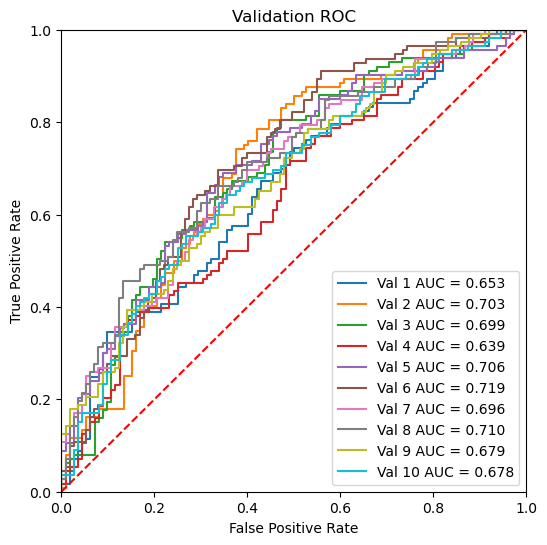

In [43]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

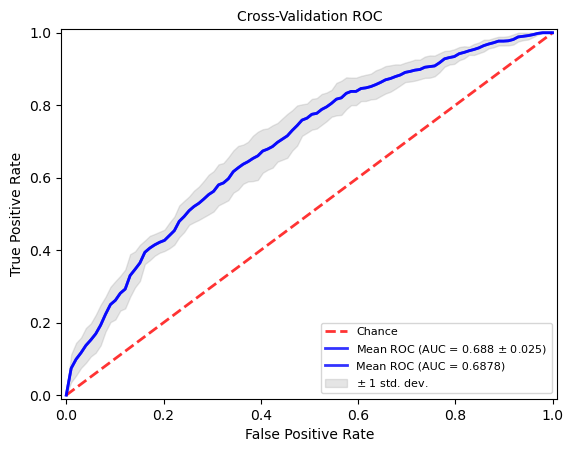

In [44]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [45]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [46]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [47]:
my_calculate_metrics_list_val

[{'SN': 0.7168141592920354,
  'SP': 0.5089285714285714,
  'ACC': 0.6133333333333333,
  'MCC': 0.23083281605527498,
  'Recall': 0.7168141592920354,
  'Precision': 0.5955882352941176,
  'F1-score': 0.6506024096385542,
  'Cutoff': 0.5},
 {'SN': 0.8035714285714286,
  'SP': 0.5267857142857143,
  'ACC': 0.6651785714285714,
  'MCC': 0.343788381891804,
  'Recall': 0.8035714285714286,
  'Precision': 0.6293706293706294,
  'F1-score': 0.7058823529411765,
  'Cutoff': 0.5},
 {'SN': 0.4424778761061947,
  'SP': 0.8303571428571429,
  'ACC': 0.6355555555555555,
  'MCC': 0.2958431382300307,
  'Recall': 0.4424778761061947,
  'Precision': 0.7246376811594203,
  'F1-score': 0.5494505494505495,
  'Cutoff': 0.5},
 {'SN': 0.7699115044247787,
  'SP': 0.45535714285714285,
  'ACC': 0.6133333333333333,
  'MCC': 0.23739565393581463,
  'Recall': 0.7699115044247787,
  'Precision': 0.5878378378378378,
  'F1-score': 0.6666666666666666,
  'Cutoff': 0.5},
 {'SN': 0.7610619469026548,
  'SP': 0.5535714285714286,
  'ACC': 0

In [48]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.716814,0.508929,0.613333,0.230833,0.716814,0.595588,0.650602,0.5
1,0.803571,0.526786,0.665179,0.343788,0.803571,0.629371,0.705882,0.5
2,0.442478,0.830357,0.635556,0.295843,0.442478,0.724638,0.549451,0.5
3,0.769912,0.455357,0.613333,0.237396,0.769912,0.587838,0.666667,0.5
4,0.761062,0.553571,0.657778,0.321728,0.761062,0.632353,0.690763,0.5
5,0.410714,0.814159,0.613333,0.245879,0.410714,0.686567,0.513966,0.5
6,0.428571,0.769912,0.600000,0.211236,0.428571,0.648649,0.516129,0.5
7,0.625000,0.690265,0.657778,0.315965,0.625000,0.666667,0.645161,0.5
8,0.598214,0.628319,0.613333,0.226640,0.598214,0.614679,0.606335,0.5
9,0.500000,0.750000,0.625000,0.258199,0.500000,0.666667,0.571429,0.5


In [49]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.716814,0.508929,0.613333,0.230833,0.716814,0.595588,0.650602,0.5
1,0.803571,0.526786,0.665179,0.343788,0.803571,0.629371,0.705882,0.5
2,0.442478,0.830357,0.635556,0.295843,0.442478,0.724638,0.549451,0.5
3,0.769912,0.455357,0.613333,0.237396,0.769912,0.587838,0.666667,0.5
4,0.761062,0.553571,0.657778,0.321728,0.761062,0.632353,0.690763,0.5
5,0.410714,0.814159,0.613333,0.245879,0.410714,0.686567,0.513966,0.5
6,0.428571,0.769912,0.600000,0.211236,0.428571,0.648649,0.516129,0.5
7,0.625000,0.690265,0.657778,0.315965,0.625000,0.666667,0.645161,0.5
8,0.598214,0.628319,0.613333,0.226640,0.598214,0.614679,0.606335,0.5
9,0.500000,0.750000,0.625000,0.258199,0.500000,0.666667,0.571429,0.5


In [50]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [51]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [52]:
roc_auc_list_indep

[0.6953922193877551,
 0.6633450255102041,
 0.681122448979592,
 0.6835140306122449,
 0.7166772959183674,
 0.6686862244897959,
 0.6966677295918368,
 0.6537786989795918,
 0.6713169642857143,
 0.6862244897959184]

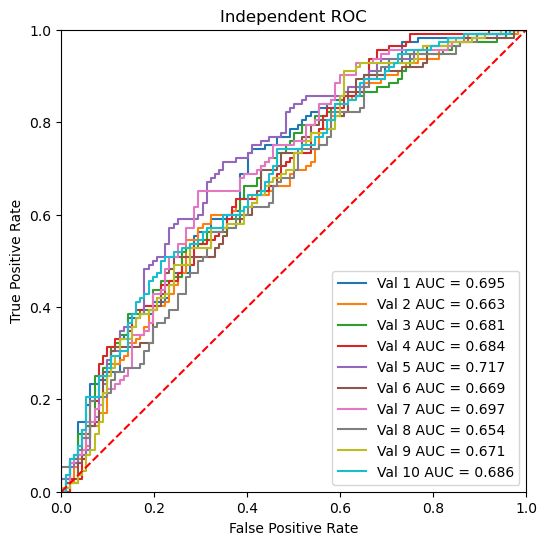

In [53]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

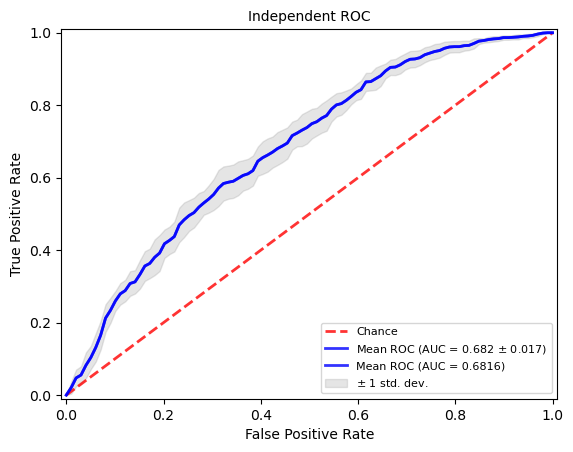

In [54]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [55]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [56]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [57]:
my_calculate_metrics_list_indep

[{'SN': 0.7410714285714286,
  'SP': 0.5625,
  'ACC': 0.6517857142857143,
  'MCC': 0.3085304536722668,
  'Recall': 0.7410714285714286,
  'Precision': 0.6287878787878788,
  'F1-score': 0.680327868852459,
  'Cutoff': 0.5},
 {'SN': 0.6964285714285714,
  'SP': 0.48214285714285715,
  'ACC': 0.5892857142857143,
  'MCC': 0.18281810603178267,
  'Recall': 0.6964285714285714,
  'Precision': 0.5735294117647058,
  'F1-score': 0.6290322580645161,
  'Cutoff': 0.5},
 {'SN': 0.39285714285714285,
  'SP': 0.8125,
  'ACC': 0.6026785714285714,
  'MCC': 0.22624166878523208,
  'Recall': 0.39285714285714285,
  'Precision': 0.676923076923077,
  'F1-score': 0.4971751412429379,
  'Cutoff': 0.5},
 {'SN': 0.75,
  'SP': 0.4642857142857143,
  'ACC': 0.6071428571428571,
  'MCC': 0.22360679774997896,
  'Recall': 0.75,
  'Precision': 0.5833333333333334,
  'F1-score': 0.65625,
  'Cutoff': 0.5},
 {'SN': 0.7589285714285714,
  'SP': 0.5535714285714286,
  'ACC': 0.65625,
  'MCC': 0.3193053217106511,
  'Recall': 0.7589285714

In [58]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.741071,0.562500,0.651786,0.308530,0.741071,0.628788,0.680328,0.5
1,0.696429,0.482143,0.589286,0.182818,0.696429,0.573529,0.629032,0.5
2,0.392857,0.812500,0.602679,0.226242,0.392857,0.676923,0.497175,0.5
3,0.750000,0.464286,0.607143,0.223607,0.750000,0.583333,0.656250,0.5
4,0.758929,0.553571,0.656250,0.319305,0.758929,0.629630,0.688259,0.5
5,0.321429,0.821429,0.571429,0.164957,0.321429,0.642857,0.428571,0.5
6,0.428571,0.803571,0.616071,0.250417,0.428571,0.685714,0.527473,0.5
7,0.437500,0.732143,0.584821,0.177524,0.437500,0.620253,0.513089,0.5
8,0.580357,0.633929,0.607143,0.214594,0.580357,0.613208,0.596330,0.5
9,0.508929,0.758929,0.633929,0.276642,0.508929,0.678571,0.581633,0.5


In [59]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.741071,0.562500,0.651786,0.308530,0.741071,0.628788,0.680328,0.5
1,0.696429,0.482143,0.589286,0.182818,0.696429,0.573529,0.629032,0.5
2,0.392857,0.812500,0.602679,0.226242,0.392857,0.676923,0.497175,0.5
3,0.750000,0.464286,0.607143,0.223607,0.750000,0.583333,0.656250,0.5
4,0.758929,0.553571,0.656250,0.319305,0.758929,0.629630,0.688259,0.5
5,0.321429,0.821429,0.571429,0.164957,0.321429,0.642857,0.428571,0.5
6,0.428571,0.803571,0.616071,0.250417,0.428571,0.685714,0.527473,0.5
7,0.437500,0.732143,0.584821,0.177524,0.437500,0.620253,0.513089,0.5
8,0.580357,0.633929,0.607143,0.214594,0.580357,0.613208,0.596330,0.5
9,0.508929,0.758929,0.633929,0.276642,0.508929,0.678571,0.581633,0.5


In [60]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_1\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

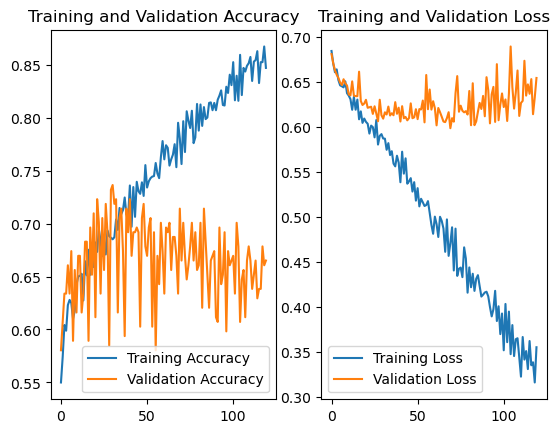

In [62]:

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()